In [1]:
import sys
  
  
print("User Current Version:-", sys.version)

User Current Version:- 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:34:17) [MSC v.1929 64 bit (AMD64)]


# Udacity project: Write a Data Science blog post
## Analyzing the 2021 and 2018 Mexican Chamber of Deputies elections

This project is a part of Udacity's Data Science Nanodegree, where I analyze the results of the 2021 and 2018 Mexican legislative elections with the purpose of effectively communicating technical results, and follows the CRISP-DM data science process.

# 1. Business Understanding

For this project, I will be analyzing the results of the 2021 Mexican legislative midterm election for the 300 Chamber of Deputies districts, and comparing the outcome with the 2018 Mexican federal election.

Mexico uses a mixed-member majoritarian system to elect the 500 members of the lower house of the Congress of the Union: **300 members competing in individual districts using a first-past-the-post electoral system**, and another 200 elected through proportional representation from five regional constituencies. Since the end result isn't strictly proportional, a consequence of complex rules preventing under- and over-representation, I will be limiting my analysis to the 300 FTPT districts.

The 2018 Mexican federal election held contests for the presidency, the Chamber of Deputies (lower house), and the Senate (upper house), with the Morena party and its allies, the Labor Party (PT) and the Social Encounter Party (PES) winning the presidency and a majority in both chambers.

The 2021 midterm elections renewed only the entirety of the Chamber of Deputies. Morena, the Labor Party, and their new allies the Green Party (PVEM) retained a slimmer majority. This election also marks the first time lawmakers were allowed to run for reelection.

The datasets with election results and candidates were downloaded from the official website of the National Electoral Institute (INE): [2018 results](https://computos2018.ine.mx/#/diputaciones/nacional/1/3/1/1), [2021 results](https://computos2021.ine.mx/votos-distrito/mapa). In addition, I downloaded a shape file for the map of the country's territorial divisions from the [CONABIO](http://www.conabio.gob.mx/informacion/metadata/gis/destdv250k_2gw.xml?_xsl=/db/metadata/xsl/fgdc_html.xsl&_indent=no).

**The purpose of this project is to answer the following three questions as related to the election results:**

1. For the 2021 election, three of the main oppositon parties formed a united center-left to center-right coaltion to try to block Morena's continued electoral success; a fourth opposition party (Citizen's Movement (MC)) refused to join the alliance and participated alone. **What would have happened if all four opposition parties ran together against Morena in every one of the 300 FTPT districts?**
2. **In which states did Morena lose or gain support in 2021 compared to the 2018 Chamber of Deputies election?**
3. **Did parties benefit in 2021 from the new reelection rules by renominating incumbents compared to their results in open seats?**

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
pd.options.mode.chained_assignment = None  # default='warn'

# 2. Data Understanding

Importing the datasets, inspecting the data for missing values, presenting descriptive statistics, visualizing distributions.

## Importing Datasets

In [61]:
# Election results per parties for each of the legislative election cycles
results_2021_df = pd.read_csv('data/2021/diputaciones.csv', sep="|", encoding='latin-1', skiprows=6)
results_2018_df = pd.read_csv('data/2018/diputaciones.csv', sep="|", encoding='latin-1', skiprows=6, low_memory=False)

In [62]:
# Candidates for each of the legislative election cycles
candidacies_2018_df = pd.read_csv('data/2018/diputaciones_candidaturas_2018.csv', sep="|", encoding='latin-1', skiprows=1)
candidacies_2021_df = pd.read_csv('data/2021/diputaciones_candidaturas_2021.csv', sep="|", encoding='latin-1', skiprows=1)

## 2021 Chamber of Deputies Election

Inspecting the 2021 results data.

In [63]:
results_2021_df.head()

,TIPO_CANDIDATURA,ID_ESTADO,NOMBRE_ESTADO,ID_DISTRITO,NOMBRE_DISTRITO,PAN,PRI,PRD,PVEM,PT,MC,MORENA,PES,RSP,FXM,CANDIDATO/A NO REGISTRADO/A,VOTOS NULOS,TOTAL_VOTOS_CALCULADOS,FECHA_HORA
0,RP,1,AGUASCALIENTES,1,JESUS MARIA,62687,23717,8034,11731,7696,6494,48317,3184,2208,9231,-,-,190528,13/06/2021 08:06:55
1,RP,1,AGUASCALIENTES,2,AGUASCALIENTES,64670,10097,3629,3228,2479,6339,41285,2433,1049,2872,-,-,143314,13/06/2021 08:06:54
2,RP,1,AGUASCALIENTES,3,AGUASCALIENTES,101758,12857,2692,3473,1987,7128,38946,2243,975,3108,-,-,180246,13/06/2021 08:06:55
3,RP,2,BAJA CALIFORNIA,1,MEXICALI,23902,6650,1307,3351,2172,8432,59514,20582,1632,2650,-,-,134363,13/06/2021 08:06:04
4,RP,2,BAJA CALIFORNIA,2,MEXICALI,32136,9237,1461,2713,1816,7999,58174,22197,2273,2546,-,-,145757,13/06/2021 08:06:24


There are 300 results, a row per each district.

In [64]:
results_2021_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   TIPO_CANDIDATURA             300 non-null    object
 1   ID_ESTADO                    300 non-null    int64 
 2   NOMBRE_ESTADO                300 non-null    object
 3   ID_DISTRITO                  300 non-null    int64 
 4   NOMBRE_DISTRITO              300 non-null    object
 5   PAN                          300 non-null    int64 
 6   PRI                          300 non-null    int64 
 7   PRD                          300 non-null    int64 
 8   PVEM                         300 non-null    int64 
 9   PT                           300 non-null    int64 
 10  MC                           300 non-null    int64 
 11  MORENA                       300 non-null    int64 
 12  PES                          300 non-null    int64 
 13  RSP                          300 no

In [65]:
results_2021_df.describe()

,ID_ESTADO,ID_DISTRITO,PAN,PRI,PRD,PVEM,PT,MC,MORENA,PES,RSP,FXM,TOTAL_VOTOS_CALCULADOS
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.000000,300.000000
mean,16.476667,8.523333,29897.626667,29052.996667,5975.666667,8903.323333,5316.093333,11499.940000,55866.390000,4508.48000,2895.050000,4056.946667,163690.030000
std,7.939747,8.140250,24763.599266,17025.614023,6846.922665,9899.983000,4452.039218,12958.384774,16786.009724,4227.89523,3227.486204,3010.513500,26750.328063
min,1.000000,1.000000,866.000000,3296.000000,486.000000,1188.000000,728.000000,1695.000000,14624.000000,611.00000,369.000000,563.000000,102320.000000
25%,11.000000,3.000000,12041.000000,15808.000000,1913.000000,3468.500000,2442.250000,4114.000000,45661.000000,2285.50000,1170.250000,2183.250000,143934.750000
50%,15.000000,6.000000,21128.500000,25936.000000,3335.500000,5410.000000,3483.000000,6362.000000,57396.500000,3227.50000,1906.500000,3144.000000,161886.500000
75%,22.000000,11.000000,43025.500000,37640.000000,7847.750000,9366.500000,7007.250000,11628.250000,66607.000000,5102.50000,3265.500000,5042.500000,182235.000000
max,32.000000,41.000000,143586.000000,90787.000000,50296.000000,68133.000000,28089.000000,72639.000000,96941.000000,28160.00000,32236.000000,25630.000000,239168.000000


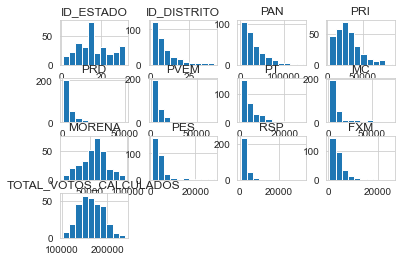

In [66]:
results_2021_df.hist();

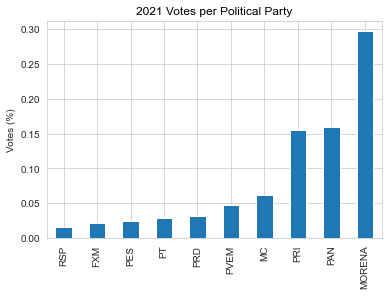

In [67]:
(results_2021_df[['PAN', 'PRI', 'PRD', 'PVEM', 'PT', 'MC', 'MORENA', 'PES', 'RSP', 'FXM']].sum()\
                                         /results_2018_df.TOTAL_VOTOS_CALCULADOS.sum()).sort_values().plot(kind='bar')

plt.ticklabel_format(style='plain', axis='y')
plt.title('2021 Votes per Political Party', color='black');
plt.ylabel('Votes (%)');

### 2021 Candidacies

Inspecting the 2021 candidates list. From here we can extract coalition details.

In [68]:
candidacies_2021_df.head()

,ESTADO,DISTRITO,PARTIDO_CI,CANDIDATURA_PROPIETARIA,CANDIDATURA_SUPLENTE
0,1,1,PAN,NOEL MATA ATILANO,ARNULFO FEDERICO VARGAS GOMEZ
1,1,1,PRI,NOEL MATA ATILANO,ARNULFO FEDERICO VARGAS GOMEZ
2,1,1,PRD,NOEL MATA ATILANO,ARNULFO FEDERICO VARGAS GOMEZ
3,1,1,PVEM,CLAUDIA BRISEIDA CHAVEZ RAMIREZ,MELANNIE ITZAYANA REYES MARTINEZ
4,1,1,PT,JUAN MANUEL DE LOERA MARQUEZ,LILIA RODRIGUEZ GUERRERO


In [69]:
candidacies_2021_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4611 entries, 0 to 4610
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ESTADO                   4611 non-null   int64 
 1   DISTRITO                 4611 non-null   int64 
 2   PARTIDO_CI               4611 non-null   object
 3   CANDIDATURA_PROPIETARIA  4611 non-null   object
 4   CANDIDATURA_SUPLENTE     4611 non-null   object
dtypes: int64(2), object(3)
memory usage: 180.2+ KB


## 2018 Chamber of Deputies Election

Inspecting the 2018 results data.

In [70]:
results_2018_df.head()

,CLAVE_CASILLA,CLAVE_ACTA,ID_ESTADO,NOMBRE_ESTADO,ID_DISTRITO,NOMBRE_DISTRITO,SECCION,ID_CASILLA,TIPO_CASILLA,EXT_CONTIGUA,...,CAND_IND_02,CNR,VN,TOTAL_VOTOS_CALCULADOS,LISTA_NOMINAL_CASILLA,OBSERVACIONES,MECANISMOS_TRASLADO,FECHA_HORA,Unnamed: 42,Unnamed: 43
0,'010338B0100',010338B010006,1,AGUASCALIENTES,1,JESÚS MARÍA,338,1,B,0,...,-,1,25,337,587,Cotejo (Levantada en Casilla),F,05/07/18 09:37:16.275000,NaN,NaN
1,'010338C0100',010338C010006,1,AGUASCALIENTES,1,JESÚS MARÍA,338,1,C,0,...,-,0,13,336,586,Cotejo (Levantada en Casilla),F,05/07/18 09:39:07.887000,NaN,NaN
2,'010338C0200',010338C020006,1,AGUASCALIENTES,1,JESÚS MARÍA,338,2,C,0,...,-,0,17,305,586,Recuento (Para recuento (SRA)),F,05/07/18 10:33:15.991000,NaN,NaN
3,'010339B0100',010339B010006,1,AGUASCALIENTES,1,JESÚS MARÍA,339,1,B,0,...,-,0,12,328,552,Cotejo (Levantada en Casilla),F-D,05/07/18 09:40:54.747000,NaN,NaN
4,'010339C0100',010339C010006,1,AGUASCALIENTES,1,JESÚS MARÍA,339,1,C,0,...,-,0,15,319,552,Recuento (Para recuento (SRA)),F-D,05/07/18 10:35:55.072000,NaN,NaN


It appears that unlike the previous dataset, the results are presented by precint, not consolidate by district. Also, the results columns are not numeric values.

In [71]:
results_2018_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157859 entries, 0 to 157858
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CLAVE_CASILLA           157859 non-null  object 
 1   CLAVE_ACTA              157859 non-null  object 
 2   ID_ESTADO               157859 non-null  int64  
 3   NOMBRE_ESTADO           157859 non-null  object 
 4   ID_DISTRITO             157859 non-null  int64  
 5   NOMBRE_DISTRITO         157859 non-null  object 
 6   SECCION                 157859 non-null  int64  
 7   ID_CASILLA              157859 non-null  int64  
 8   TIPO_CASILLA            157859 non-null  object 
 9   EXT_CONTIGUA            157859 non-null  int64  
 10  CASILLA                 157859 non-null  object 
 11  NUM_ACTA_IMPRESO        157859 non-null  int64  
 12  PAN                     157859 non-null  object 
 13  PRI                     157859 non-null  object 
 14  PRD                 

In [72]:
results_2018_df.describe()

,ID_ESTADO,ID_DISTRITO,SECCION,ID_CASILLA,EXT_CONTIGUA,NUM_ACTA_IMPRESO,TOTAL_VOTOS_CALCULADOS,Unnamed: 42,Unnamed: 43
count,157859.000000,157859.000000,157859.000000,157859.000000,157859.000000,157859.000000,157859.000000,0.0,0.0
mean,16.521744,8.272883,1595.176575,1.563674,0.053592,6.019974,356.648953,NaN,NaN
std,8.060766,7.900829,1374.572383,1.610096,0.498491,0.181357,100.330112,NaN,NaN
min,1.000000,1.000000,1.000000,1.000000,0.000000,6.000000,0.000000,NaN,NaN
25%,10.000000,3.000000,538.000000,1.000000,0.000000,6.000000,296.000000,NaN,NaN
50%,15.000000,6.000000,1219.000000,1.000000,0.000000,6.000000,365.000000,NaN,NaN
75%,22.000000,11.000000,2257.000000,1.000000,0.000000,6.000000,426.000000,NaN,NaN
max,32.000000,41.000000,6516.000000,28.000000,20.000000,8.000000,908.000000,NaN,NaN


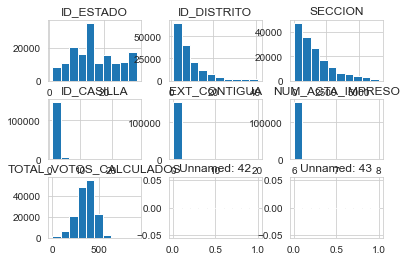

In [73]:
results_2018_df.hist();

In [74]:
# Convert each individual party results to numeric
numeric_cols = ['PAN', 'PRI', 'PRD', 'PVEM', 'PT', 'MOVIMIENTO CIUDADANO', 'NUEVA ALIANZA',
       'MORENA', 'ENCUENTRO SOCIAL', 'PAN_PRD_MC', 'PAN_PRD', 'PAN_MC',
       'PRD_MC', 'PRI_PVEM_NA', 'PRI_PVEM', 'PRI_NA', 'PVEM_NA',
       'PT_MORENA_PES', 'PT_MORENA', 'PT_PES', 'MORENA_PES', 'CAND_IND_01',
       'CAND_IND_02', 'CNR', 'VN', 'TOTAL_VOTOS_CALCULADOS']

results_2018_df[numeric_cols] = results_2018_df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

Morena seems to have lost about 5% of the votes when comparing 2021 to the following 2018 results:

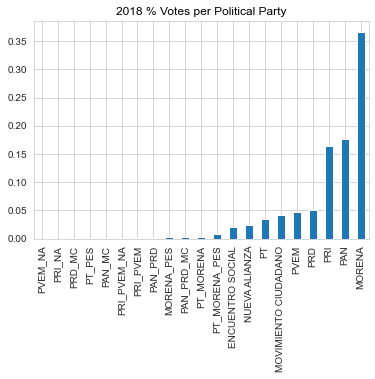

In [75]:
(results_2018_df[['PAN', 'PRI', 'PRD', 'PVEM', 'PT', 'MOVIMIENTO CIUDADANO', 'NUEVA ALIANZA', 'MORENA', 'ENCUENTRO SOCIAL', 
                 'PAN_PRD_MC', 'PAN_PRD', 'PAN_MC', 'PRD_MC', 'PRI_PVEM_NA', 'PRI_PVEM', 'PRI_NA', 'PVEM_NA', 'PT_MORENA_PES', 
                 'PT_MORENA', 'PT_PES', 'MORENA_PES']].sum().sort_values() \
                                                         /results_2018_df.TOTAL_VOTOS_CALCULADOS.sum()).plot(kind='bar')

plt.ticklabel_format(style='plain', axis='y')
plt.title('2018 % Votes per Political Party', color='black');

### 2018 Candidacies

Again, from the 2018 candidates list we can extract coalition details.

In [76]:
candidacies_2018_df.head()

,ESTADO,DISTRITO,PARTIDO_CI,CANDIDATURA_PROPIETARIA,CANDIDATURA_SUPLENTE
0,1,1,PAN,FRANCISCO JAVIER LUEVANO NUÑEZ,GUSTAVO ARMENDARIZ VIRAMONTES
1,1,1,PRI,NORMA ESPARZA HERRERA,FABIOLA MEDINA DE LUNA
2,1,1,PRD,FRANCISCO JAVIER LUEVANO NUÑEZ,GUSTAVO ARMENDARIZ VIRAMONTES
3,1,1,PVEM,SAMANTHA WENDOLYN REYES MARTÍNEZ,ALBA VIVIANA GUTIERREZ VEGA
4,1,1,PT,RAFAEL CALDERON ZAMARRIPA,ANTONIO ALBERTO MARTINEZ RODRIGUEZ


In [77]:
candidacies_2018_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ESTADO                   5570 non-null   int64 
 1   DISTRITO                 5570 non-null   int64 
 2   PARTIDO_CI               5570 non-null   object
 3   CANDIDATURA_PROPIETARIA  5570 non-null   object
 4   CANDIDATURA_SUPLENTE     5570 non-null   object
dtypes: int64(2), object(3)
memory usage: 217.7+ KB


# 3. Data Preparation

Clean data, aggregate results, and create dataframes with coalitions running per district, coalitions shared results, and final winner as basis for further analysis/evaluation.

## Candidacies

Establish coalitions for each election cycle (as you can see, some parties switched their support or abandoned previous alliances) and get a dataframe per cycle indicating in which districts the coalitions ran (allied parties did not participate together in _every single district_).

In [78]:
def get_coalitions(df, coalition_list):
    """Creates dataframe with each electoral district, indicating whether each coalition ran in that district
    or the parties ran individually.

    Args:
        df: Dataframe containing candidates and their parties for each district.
        coalition_list: List of lists containing each coalition participating, and their individual members.
    Returns:
        A dataframe with state and district ID, and a one hot encoding indicating whether each coalition participated in full.

    """

    coalitions_df = df[df.PARTIDO_CI.isin(coalition_list)]\
                        .rename(columns={'PARTIDO_CI':'COALITION',
                                        'ESTADO':'ID_ESTADO',
                                        'DISTRITO':'ID_DISTRITO'})[['ID_ESTADO', 'ID_DISTRITO', 'COALITION']].drop_duplicates()

    coalitions_df = pd.get_dummies(coalitions_df,
                                   columns=['COALITION']).groupby(['ID_ESTADO', 'ID_DISTRITO'], as_index=False).sum()
    
    return coalitions_df

In [79]:
coalitions_2021_lists = [['PAN', 'PRI', 'PRD'], ['PVEM', 'PT', 'MORENA']]
coalitions_2018_lists = [['PT', 'MORENA', 'PES'], ['PRI', 'PVEM', 'NA'], ['PAN', 'PRD', 'MC']]

# Get Dataframe with info on which districts had alliances
coalitions_2021_df = get_coalitions(candidacies_2021_df, ['_'.join(x) for x in coalitions_2021_lists])
coalitions_2018_df = get_coalitions(candidacies_2018_df, ['_'.join(x) for x in coalitions_2018_lists])

## 2018 Results

In [80]:
# Preprocessing

# Rename parties with initials
results_2018_df.rename(columns={'ENCUENTRO SOCIAL':'PES',
                                'MOVIMIENTO CIUDADANO':'MC',
                                'NUEVA ALIANZA':'NA'}, inplace=True)

# Reassign coaliton votes, as some voters have voted for individual parties in each coalition, 
# some just for one of the individual parties
results_2018_df['PAN'] += results_2018_df['PAN_PRD_MC']/3 + results_2018_df['PAN_MC']/2 + results_2018_df['PAN_PRD']/2
results_2018_df['PRI'] += results_2018_df['PRI_PVEM_NA']/3 + results_2018_df['PRI_PVEM']/2 + results_2018_df['PRI_NA']/2
results_2018_df['PRD'] += results_2018_df['PAN_PRD_MC']/3 + results_2018_df['PRD_MC']/2 + results_2018_df['PAN_PRD']/2
results_2018_df['PVEM'] += results_2018_df['PRI_PVEM_NA']/3 + results_2018_df['PRI_PVEM']/2 + results_2018_df['PVEM_NA']/2
results_2018_df['PT'] += results_2018_df['PT_MORENA_PES']/3 + results_2018_df['PT_MORENA']/2 + results_2018_df['PT_PES']/2
results_2018_df['MC'] += results_2018_df['PAN_PRD_MC']/3 + results_2018_df['PAN_MC']/2 + results_2018_df['PRD_MC']/2
results_2018_df['NA'] += results_2018_df['PRI_PVEM_NA']/3 + results_2018_df['PVEM_NA']/2 + results_2018_df['PRI_NA']/2
results_2018_df['MORENA'] += results_2018_df['PT_MORENA_PES']/3 + results_2018_df['PT_MORENA']/2 + \
                            results_2018_df['MORENA_PES']/2
results_2018_df['PES'] += results_2018_df['PT_MORENA_PES']/3 + results_2018_df['PT_PES']/2 + results_2018_df['MORENA_PES']/2

# Keep Relevant Columns
results_2018_df = results_2018_df[['ID_ESTADO', 'NOMBRE_ESTADO', 'ID_DISTRITO', 'PAN', 'PRI', 'PRD', 
                                   'PVEM', 'PT', 'MC', 'NA', 'MORENA', 'PES', 'TOTAL_VOTOS_CALCULADOS']]

# Eliminate precints, get results by district
results_2018_df = results_2018_df.groupby(['ID_ESTADO', 'NOMBRE_ESTADO', 'ID_DISTRITO'], as_index=False).sum()

In [81]:
def add_coalitions(results_df, coalitions_df, coalitions_lists):
    """Returns results_df adding coalition indicators from coalitions_df, and adding columns with vote results for each
    coalition.

    Args:
        results_df: Dataframe containing parties' results for each district.
        coalitions_df: Dataframe with state and district ID indicating whether each coalition participated in full.
        coalition_list: List of lists containing each coalition participating, and their individual members.
    Returns:
        A dataframe vote results by district, with coalition participation indicators, and the coalitions' joint results.
    """


    # Add Coalition
    results_df = results_df.merge(coalitions_df, how='left').fillna(0)

    # Add Coalition results
    for coalition in coalitions_lists:
        results_df['_'.join(coalition)] = results_df[coalition].sum(axis=1)
    
    return results_df

In [82]:
# Add information on which alliances were valid for each district, as well as their combined vote share
results_2018_df = add_coalitions(results_2018_df, coalitions_2018_df, coalitions_2018_lists)

In [24]:
def get_winners(df_, conditions, party_lists, winner_col = ['WINNER']):
    """Calculates each individual coalition or party winner per district with voting results.

    Args:
        df_: Dataframe with voting results per district, as well as columns indicating coalition participation.
        conditions: List of conditions indicating potential scenarios where coalitions compete against each other 
                    or go at it alone.
        party_lists: List of parties or coalitions to compare depending on each condition in conditions.
        winner_col: List with column name for winners_df column. Default is "WINNER"
    Returns:
        A dataframe with voting results per state and district ID, as well as the coalition or party winner per district.

    """
    
    df = df_.copy()
    
    winner_results_list = []
    
    for condition, party_list in zip(conditions, party_lists):
        winner_results_df = df[condition][party_list].apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)
        if not winner_results_df.empty:
            winner_results_list.append(winner_results_df)

    winners_df = pd.concat(winner_results_list).reindex(df_.index)
    winners_df.columns = winner_col

    full_df = df_.join(winners_df)
    
    return full_df

In [25]:
# Depending on which alliances were valid in each district, apply conditions to establish winner as the party (or coalition)
# with the most votes in each district

condition_1 = ((results_2018_df.COALITION_PAN_PRD_MC == 1) & (results_2018_df.COALITION_PT_MORENA_PES == 1) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 1))
condition_2 = ((results_2018_df.COALITION_PAN_PRD_MC == 1) & (results_2018_df.COALITION_PT_MORENA_PES == 1) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 0))
condition_3 = ((results_2018_df.COALITION_PAN_PRD_MC == 1) & (results_2018_df.COALITION_PT_MORENA_PES == 0) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 1))
condition_4 = ((results_2018_df.COALITION_PAN_PRD_MC == 0) & (results_2018_df.COALITION_PT_MORENA_PES == 1) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 1))
condition_5 = ((results_2018_df.COALITION_PAN_PRD_MC == 0) & (results_2018_df.COALITION_PT_MORENA_PES == 0) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 0))
condition_6 = ((results_2018_df.COALITION_PAN_PRD_MC == 1) & (results_2018_df.COALITION_PT_MORENA_PES == 0) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 0))
condition_7 = ((results_2018_df.COALITION_PAN_PRD_MC == 0) & (results_2018_df.COALITION_PT_MORENA_PES == 1) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 0))
condition_8 = ((results_2018_df.COALITION_PAN_PRD_MC == 0) & (results_2018_df.COALITION_PT_MORENA_PES == 0) & \
               (results_2018_df.COALITION_PRI_PVEM_NA == 1))

# Depending on conditions establishing which alliances were valid, only compare relevant parties to find winner
party_list_1 = ['PAN_PRD_MC', 'PT_MORENA_PES', 'PRI_PVEM_NA'] # First example, all three alliances competed against each other
party_list_2 = ['PAN_PRD_MC', 'PT_MORENA_PES', 'PRI', 'PVEM', 'NA']
party_list_3 = ['PAN_PRD_MC', 'PRI_PVEM_NA', 'MORENA', 'PES', 'PT']
party_list_4 = ['PRI_PVEM_NA', 'PT_MORENA_PES', 'PAN', 'PRD', 'MC']

# Here (5), there were no alliances, and everyone ran against each other:
party_list_5 = ['PAN', 'PRD', 'MC', 'PRI', 'PVEM', 'NA', 'MORENA', 'PES', 'PT']
party_list_6 = ['PAN_PRD_MC', 'PRI', 'PVEM', 'NA', 'MORENA', 'PES', 'PT']
party_list_7 = ['PAN', 'PRD', 'MC', 'PRI', 'PVEM', 'NA', 'PT_MORENA_PES']
party_list_8 = ['PAN', 'PRD', 'MC', 'PRI_PVEM_NA', 'MORENA', 'PES', 'PT']

conditions_2018 = [condition_1, condition_2, condition_3, condition_4, condition_5, condition_6, condition_7, condition_8]
party_lists_2018 = [party_list_1, party_list_2, party_list_3, party_list_4, 
                    party_list_5, party_list_6, party_list_7, party_list_8]

# Get winners per coalition - the function returns a df with Winner column indicating the winning party or coalition
final_results_2018_df = get_winners(results_2018_df, conditions_2018, party_lists_2018)

## 2021 Results

In [26]:
# Keep relevant columns
results_2021_df = results_2021_df[['ID_ESTADO', 'NOMBRE_ESTADO', 'ID_DISTRITO', 'PAN', 'PRI', 'PRD', 'PVEM', 'PT', 'MC', 
                                   'MORENA', 'PES', 'RSP', 'FXM', 'TOTAL_VOTOS_CALCULADOS']]

# Add information on which alliances were valid for each district, as well as their combined vote share
results_2021_df = add_coalitions(results_2021_df, coalitions_2021_df, coalitions_2021_lists)

In [27]:
# Depending on which alliances were valid in each district, apply conditions to establish winner as the party (or coalition)
# with the most votes in each district

condition_1 = ((results_2021_df.COALITION_PAN_PRI_PRD == 1) & (results_2021_df.COALITION_PVEM_PT_MORENA == 1))
condition_2 = ((results_2021_df.COALITION_PAN_PRI_PRD == 1) & (results_2021_df.COALITION_PVEM_PT_MORENA == 0))
condition_3 = ((results_2021_df.COALITION_PAN_PRI_PRD == 0) & (results_2021_df.COALITION_PVEM_PT_MORENA == 1))
condition_4 = ((results_2021_df.COALITION_PAN_PRI_PRD == 0) & (results_2021_df.COALITION_PVEM_PT_MORENA == 0))

party_list_1 = ['PAN_PRI_PRD', 'PVEM_PT_MORENA', 'MC', 'PES', 'RSP', 'FXM']
party_list_2 = ['PVEM', 'PT', 'MC', 'MORENA', 'PAN_PRI_PRD', 'PES', 'RSP', 'FXM']
party_list_3 = ['PAN', 'PRI', 'PRD', 'MC', 'PVEM_PT_MORENA', 'PES', 'RSP', 'FXM']
party_list_4 = ['PAN', 'PRI', 'PRD', 'PVEM', 'PT', 'MC', 'MORENA', 'PES', 'RSP', 'FXM']

conditions_2021 = [condition_1, condition_2, condition_3, condition_4]
party_lists_2021 = [party_list_1, party_list_2, party_list_3, party_list_4]

# Get winners per coalition - the function returns a df with Winner column indicating the winning party or coalition
final_results_2021_df = get_winners(results_2021_df, conditions_2021, party_lists_2021)

# 4. Evaluating the Results

## Question 1: What would have happened if all four opposition parties ran together against Morena in every one of the 300 FTPT districts?

For the first question, I will create a new "coalition" combining the votes of the four opposition parties: PAN, PRD, PRI, MC. I will assume that they would run in together *every* district (which was not the case during the actual election even with the first three official allies), and that such an alliance would have resulted in the same number of votes, just added together.

In [28]:
# Get potential winner with united opposition

# Add up results from PAN, PRI, PRD, and MC
final_results_2021_df['OPPOSITION'] = final_results_2021_df[['PAN', 'PRI', 'PRD', 'MC']].sum(axis=1)

# Compete against Morena coalition or exclusively Morena
condition_1 = (final_results_2021_df.COALITION_PVEM_PT_MORENA == 1)
condition_2 = (final_results_2021_df.COALITION_PVEM_PT_MORENA == 0)

party_list_1 = ['OPPOSITION', 'PVEM_PT_MORENA']
party_list_2 = ['PVEM', 'PT', 'MORENA', 'OPPOSITION']

conditions_full_opp = [condition_1, condition_2]
party_lists_full_opp = [party_list_1, party_list_2]

# Get winners per coalition - the function returns a df with Potential Winner column indicating the winning party or coalition
# under hypothetical scenario, for easy comparison to actual Winners in 2021
final_results_2021_df = get_winners(final_results_2021_df, conditions_full_opp, 
                                   party_lists_full_opp, winner_col = ['POTENTIAL_WINNER'])

# Retain relevante columns
results_full_opp_2021_df = final_results_2021_df[['ID_ESTADO', 'NOMBRE_ESTADO', 'ID_DISTRITO', 'WINNER', 'POTENTIAL_WINNER']]

# Rename for easy understanding: 
#           - PAN, PRI, PRD, and MC are the "Opposition"
#           - MORENA, PT, and PVEM support the government's "Fourth Transformation", colloquially know as the "4T"

results_full_opp_2021_df = results_full_opp_2021_df.replace({'PAN_PRI_PRD':'OPPOSITION',
                                                             'PAN':'OPPOSITION',
                                                             'PRD':'OPPOSITION',
                                                             'PRI':'OPPOSITION',
                                                             'MC':'OPPOSITION',
                                                             'PVEM_PT_MORENA':'4T',
                                                             'MORENA':'4T',
                                                             'PVEM':'4T',
                                                             'PT':'4T'})

### Results and Visualization for Q1

In [29]:
# Actual Winners in 2021 - 4T (Morena and the gov's allies) won a large majority of the 300 FPTP districts
results_full_opp_2021_df[['WINNER']].value_counts()

WINNER    
4T            186
OPPOSITION    114
dtype: int64

In [30]:
# With a united opposition, the ruling party would have lost their majority of 300 FPTP districts
results_full_opp_2021_df[['POTENTIAL_WINNER']].value_counts()

POTENTIAL_WINNER
OPPOSITION          166
4T                  134
dtype: int64

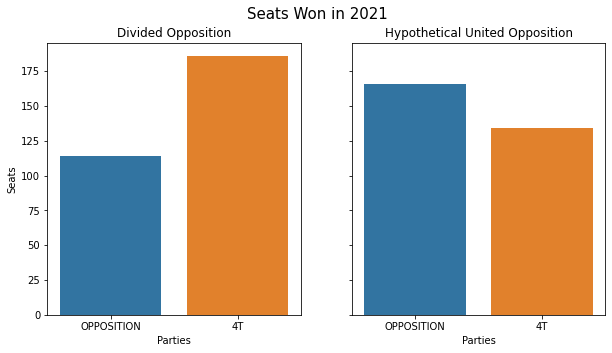

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
sns.countplot(x=results_full_opp_2021_df['WINNER'], ax=ax[0])
sns.countplot(x=results_full_opp_2021_df['POTENTIAL_WINNER'], ax=ax[1])

fig.suptitle('Seats Won in 2021', fontsize=15)

ax[0].set(xlabel='Parties', ylabel='Seats', title='Divided Opposition')
ax[1].set(xlabel='Parties', ylabel='', title='Hypothetical United Opposition');

### Q1 Conclusion

Assuming the four main opposition parties had agreed to run together as a single coalition in every one of the 300 FTPT district, and gained the same number of votes as in the 2021 election (just added up together) they would've won 166 seats (an increase of 52 deputies) and effectively denied the 4T (Morena, PT, PVEM) from gaining a majority of these 300 districts.

The actual composition of the full 500-member Chamber of Deputies is out of the scope of this project, as it would need a recomputation of the 200 proportional representation assignments to account for any over- or under-representation rules that would come into play. 

However, since these two results are mostly independent, [with "parallel" allocation](https://fruitsandvotes.wordpress.com/2021/06/11/mexico-2021/), we could assume that the PR assignment would be mostly unchanged from the actual election, [adding another 95 seats to the 4T and 105 to the Opposition](https://en.wikipedia.org/wiki/2021_Mexican_legislative_election#Results). **This hypothetical result would suggest that the Opposition would have gained control of the Chamber of Deputies** with 271 members, dethroning the ruling party and its allies.

## Question 2: In which states did Morena lose or gain support in 2021 compared to the 2018 Chamber of Deputies election?

For the second question, I will compare Morena's (an allies') change in vote share between 2018 and 2021 in each of the 32 two states of Mexico. The idea is to map out the percentage change and identify the states where Morena gained and lost most three years later.

In [32]:
def get_morena_state_vote_share(df, coalition):
    """Calculates Morena's (and allies', if applicable) vote share, aggregating by state, from district voting results.

    Args:
        df: Dataframe with voting results per district, as well as columns indicating coalition participation.
        coalition: String referencing the members of Morena's coalition separated by underscores.
    Returns:
        A dataframe aggregating Morena's vote share by state.

    """
    
    df['MORENA_VOTE'] = np.where(df[f'COALITION_{coalition}'] == 0,
                                 df['MORENA'],
                                 df[coalition])
    
    df = df.groupby(['ID_ESTADO', 'NOMBRE_ESTADO'], as_index=False).sum()[['ID_ESTADO', 'NOMBRE_ESTADO', 
                                                                           'MORENA_VOTE', 'TOTAL_VOTOS_CALCULADOS']]
    
    df['MORENA_VOTE_SHARE'] = df['MORENA_VOTE'] / df['TOTAL_VOTOS_CALCULADOS']
    
    return df[['ID_ESTADO', 'NOMBRE_ESTADO', 'MORENA_VOTE', 'MORENA_VOTE_SHARE']]

In [33]:
# Extract vote share of Morena (and allies, if applicable) in each state
morena_results_2018_df = get_morena_state_vote_share(final_results_2018_df, 'PT_MORENA_PES')
morena_results_2021_df = get_morena_state_vote_share(final_results_2021_df, 'PVEM_PT_MORENA')

# Merge vote shares for 2018 and 2021, per state
morena_results_df = morena_results_2018_df.merge(morena_results_2021_df, 
                                                 on=['ID_ESTADO', 'NOMBRE_ESTADO'], suffixes=('_2018', '_2021'))

# Substract 2018 vote share from 2021 vote share to find difference
morena_results_df['DIFF'] = morena_results_df['MORENA_VOTE_SHARE_2021'] - morena_results_df['MORENA_VOTE_SHARE_2018']
morena_results_df['DIFF'] = morena_results_df['DIFF']*100

### Results and Visualization for Q2

In [34]:
# Read shape file of Mexican states map
map_df = gpd.read_file("data/Maps/destdv250k_2gw.shp")
map_df['NUM_EDO'] = pd.to_numeric(map_df['NUM_EDO'])

# Join geopandas df with results
map_vote_share_df = map_df.set_index('NUM_EDO').join(morena_results_df.set_index('ID_ESTADO'))

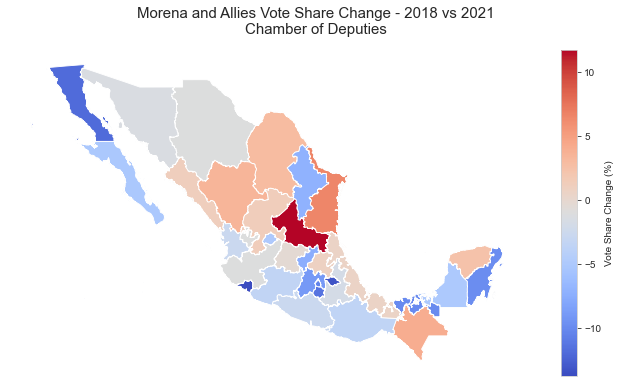

In [35]:
# Map the vote share change in each state
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(12, 6))
map_vote_share_df.plot(column='DIFF',
            cmap='coolwarm',
            linewidth=0.9,
            ax=ax,
            edgecolor='1',
            legend=True,
            legend_kwds={'label': "Vote Share Change (%)"})

fig.suptitle('Morena and Allies Vote Share Change - 2018 vs 2021\nChamber of Deputies', fontsize=15)
ax.set_axis_off()

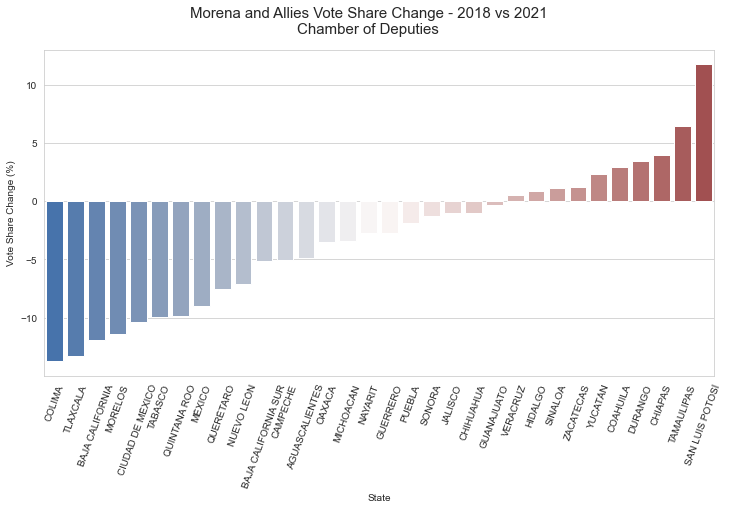

In [36]:
# Plot the vote share change in each state in ascending order
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x='NOMBRE_ESTADO', y='DIFF', data=morena_results_df.sort_values('DIFF'), palette="vlag", ax=ax)

plt.xticks(rotation=70);

fig.suptitle('Morena and Allies Vote Share Change - 2018 vs 2021\nChamber of Deputies', fontsize=15)
ax.set(xlabel='State', ylabel='Vote Share Change (%)');

### Q2 Conclusion

Morena's federal deputy candidates **lost over ten percent of their vote in the states of Colima, Tlaxcala, Baja California, Morelos, and Mexico City -- this last one being surprising, as the capital is a traditional stronghold for the left.**

**In general, Morena performed worse than in the past election in 22 of the 32 of states.** This loss of support seems to have come primarily from northwestern states like the Baja Californias, as well as in some strongholds in the center and south, like Mexico City and Tabasco, were support in 2018 was already high. The party also lost some votes in states where the left has already underperformed, like Nuevo León, Querétaro, Aguascalientes, and Guanajuato.

**Morena gained ground some states in the center and northeast of Mexico**, significantly increasing their support Chiapas, Tamaulipas, and San Luis Potosí -- the last one surpassing a 10% increase in vote share.

## Question 3: Did parties benefit in 2021 from the new reelection rules by renominating incumbents compared to their results in open seats?

For the third question, I will identify which incumbent deputies ran for reelection in 2021, and compare success of their parties in retaining their seats against open seats with no incumbents running.

In [46]:
def get_elected_deputies(candidacies_df, final_results_df):
    
    """Creates dataframe with candidates, their party/coalition, and whether they won or lost their election.

    Args:
        candidacies_df: Dataframe containing candidates and their parties for each district.
        final_results_df: A dataframe with voting results per state and district ID, as well as the coalition or 
                          party winner per district.
    Returns:
        A dataframe listing candidates per district/state, their final party/coalition, and whether they won or 
        lost their election.

    """
    
    candidacies_df.replace({'NUEVA ALIANZA':'NA',
                            'MOVIMIENTO CIUDADANO':'MC'}, inplace=True)
    
    candidacies_df['PARTIDO_CI'] = pd.Categorical(candidacies_df['PARTIDO_CI'], 
                                                   ['PRI_PVEM_NA', 'PAN_PRD_MC','PT_MORENA_PES', 'PVEM_PT_MORENA', 
                                                    'PAN_PRI_PRD', 'PAN', 'PRI', 'PRD', 'PVEM', 'PT', 'MC',  'MORENA', 
                                                    'PES', 'NA', 'RSPPPN', "FS X MÉXICO"])
    
    ind_cand_df = candidacies_df.sort_values(['ESTADO', 'DISTRITO', 'PARTIDO_CI']).drop_duplicates(['ESTADO', 
                                                                                                    'DISTRITO', 
                                                                                                    'CANDIDATURA_PROPIETARIA'])
    
    ind_cand_df.rename(columns={'ESTADO':'ID_ESTADO', 'DISTRITO':'ID_DISTRITO'}, inplace=True)
    
    ind_cand_df = ind_cand_df[['ID_ESTADO', 'ID_DISTRITO', 'PARTIDO_CI', 'CANDIDATURA_PROPIETARIA']]
    ind_cand_df['PARTIDO_CI'] = ind_cand_df['PARTIDO_CI'].str.strip()
    
    winners_df = final_results_df[['ID_ESTADO', 'ID_DISTRITO', 'WINNER']]
    winners_df.rename(columns={'WINNER':'PARTIDO_CI'}, inplace=True)
    winners_df['WON'] = True
    winners_df['PARTIDO_CI'] = winners_df['PARTIDO_CI'].str.strip()

    winners_df = ind_cand_df.merge(winners_df, how='left', on=['ID_ESTADO', 'ID_DISTRITO', 'PARTIDO_CI']).fillna(False)
    winners_df['PARTIES'] = winners_df.PARTIDO_CI.str.split('_')

    
    return winners_df   

In [47]:
# Get dataframe with candidates, their party/coalition, and whether they won or lost their election
winners_2021_df = get_elected_deputies(candidacies_2021_df, final_results_2021_df)
winners_2018_df = get_elected_deputies(candidacies_2018_df, final_results_2018_df)

In [48]:
# Merge 2018 and 2021 winners by district
winning_parties_df = winners_2018_df.query('WON == True').merge(winners_2021_df.query('WON == True'), 
                                                                on=['ID_ESTADO', 'ID_DISTRITO'], suffixes=('_2018', '_2021'))

# Check whether the incumbent party one their election (any within the original coaltion vs 2021 coalition/party)
winning_parties_df['INCUMBENT_PARTY_WON'] = [any(x in a for x in b) for a, b in zip(winning_parties_df['PARTIES_2018'], \
                                                                                  winning_parties_df['PARTIES_2021'])]

# Check if the incumbent deputy won reelection in 2021
winning_parties_df['INCUMBENT_WON'] = winning_parties_df['CANDIDATURA_PROPIETARIA_2018'] == \
                                      winning_parties_df['CANDIDATURA_PROPIETARIA_2021']

In [49]:
# Add in candidates for 2021 in case the incumbent ran but lost reelection
candidate_results_2021_df['INCUMBENT_RAN'] = True
candidate_results_2021_df.rename(columns={'CANDIDATURA_PROPIETARIA':'CANDIDATURA_PROPIETARIA_2018',
                                'PARTIES':'RENOMINATED_PARTIES'}, inplace=True)

# Add column that establishes if incumbent ran for reelection by merging 2021 on 2018 winner
winning_parties_df = winning_parties_df.merge(candidate_results_2021_df[['ID_ESTADO', 
                                                               'ID_DISTRITO', 
                                                               'CANDIDATURA_PROPIETARIA_2018',
                                                               'RENOMINATED_PARTIES',
                                                               'INCUMBENT_RAN']], how='left')

winning_parties_df['INCUMBENT_RAN'] = winning_parties_df['INCUMBENT_RAN'].fillna(False)

In [51]:
# Make sure incumbent running for reelection was renominated by at least on the original parties they ran under in 2018
# This will identify incumbents who ran for reelection after changing parties
winning_parties_df['RENOMINATED_PARTIES'] = winning_parties_df['RENOMINATED_PARTIES'].fillna("").apply(list)
winning_parties_df['INCUMBENT_PARTY_RENOMINATED'] = [any(x in a for x in b) for a, b in \
                                                     zip(winning_parties_df['PARTIES_2018'], \
                                                         winning_parties_df['RENOMINATED_PARTIES'])]

### Results and Visualization for Q3

In [52]:
winning_parties_df.query('INCUMBENT_RAN == True & INCUMBENT_PARTY_RENOMINATED == True') \
                  .INCUMBENT_PARTY_WON.value_counts(normalize=True)

True     0.730159
False    0.269841
Name: INCUMBENT_PARTY_WON, dtype: float64

In [53]:
winning_parties_df.query('INCUMBENT_RAN == False').INCUMBENT_PARTY_WON.value_counts(normalize=True)

True     0.784884
False    0.215116
Name: INCUMBENT_PARTY_WON, dtype: float64

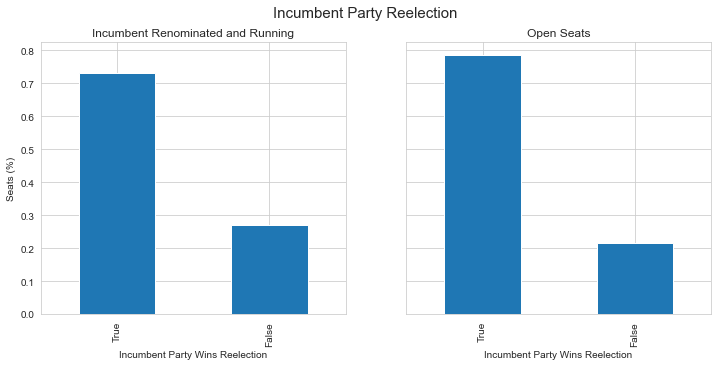

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
winning_parties_df.query('INCUMBENT_RAN == True & INCUMBENT_PARTY_RENOMINATED == True') \
                  .INCUMBENT_PARTY_WON.value_counts(normalize=True).plot(kind='bar', ax=ax[0])

winning_parties_df.query('INCUMBENT_RAN == False').INCUMBENT_PARTY_WON.value_counts(normalize=True).plot(kind='bar', ax=ax[1])

fig.suptitle('Incumbent Party Reelection', fontsize=15)

ax[0].set_title('Incumbent Renominated and Running')
ax[1].set_title('Open Seats')

ax[0].set(xlabel='Incumbent Party Wins Reelection', ylabel='Seats (%)')
ax[1].set(xlabel='Incumbent Party Wins Reelection');

### Q2 Conclusion

**There seems to be a ver little difference between party results in districts where an incumbent was renominated and ran, and in open seats. Incumbents had a 73% rate of success for their parties, whereas incumbent parties held onto to about 78% of open seats.**

Most incumbents were not renominated for reelection, with only 43% running, even [though almost 90% of the federal deputies registered to run again](https://politica.expansion.mx/congreso/2021/01/05/voces-448-diputados-buscan-reelegirse-en-2021)--this might skew the results. Also, some parties changed alliances (like the PVEM joining Morena, MC deciding to participate alone, and PAN and PRI running together), which affects which party is considered an incumbent. Lastly, this is the first time incumbent deputies are allowed to run for reelection, so voters are not used to consider such scenarios.

Right now, it does not seem like there is any sort of incumbency advantage compared to the partisanship of the district -- **in fact, incumbents running lost a larger share of seats for their parties than in those where new candidates were nominated.** It might be interesting to revisit this for the 2024 election, where some deputies will be running for their third consecutive term and might establish stronger support in their home districts.

Something else to consider would be using parlamentary group membership data to assign party incumbency, rather than which party/coalition originally nominated the incumbent, to account for party changes/unreliable coaliton support to create more precise results (this data was not available in the datasets used).